In [13]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
np.random.seed(42)

# System Parameters
T = 10  # Time slots
K = 30  # Number of UEs
N = 10  # Number of nodes
C = 6   # Number of satellites
A = 10  # Number of areas for SAR coverage

# Channel Model Parameters
P_n = 10.0  # Transmission power (W)
G_n = 20.0  # Antenna gain (dB)
G_m = 15.0  # Receiver gain (dB)
N_noise = 1e-9  # Noise power (W)
B = 10e6  # Bandwidth (Hz)
gamma_A = 0.1  # Specific attenuation (dB/km)
L_n = 5.0  # Effective path length (km)
A_exp = 0.8  # Attenuation exponent

# Cost and Latency Parameters (Sized for N=30 and C=6)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1  # Weights
Cost_local = np.random.uniform(1.0, 2.0, N).tolist()  # Local processing cost per node
Cost_bh = np.random.uniform(1.0, 3.0, (N, N))  # Backhaul cost
tau_local = np.random.uniform(0.1, 0.2, N).tolist()  # Local processing latency
tau_bh = np.random.uniform(0.1, 0.5, (N, N))  # Backhaul latency
E_SAR = np.random.uniform(5.0, 6.0, C).tolist()  # Energy cost for SAR per satellite
d_k = np.random.uniform(1e6, 2e6, K).tolist()  # Data rate requirements for UEs (bps)
d_SAR = np.random.uniform(3e6, 4e6, C).tolist()  # Data rate for SAR (bps)

# Availability Parameters
v_c_t = np.random.binomial(1, 0.8, (C, T))  # Satellite availability
g_n_t = np.random.binomial(1, 0.5, (N, T))  # Gateway availability
b_c_a_t = np.random.binomial(1, 0.7, (C, A, T))  # SAR coverage availability

# Calculate SNR and Capacity
def calculate_rain_attenuation(p):
    return gamma_A * L_n * (p / 0.01) ** A_exp

def calculate_snr(p, distance):
    rain_att = 10 ** (-calculate_rain_attenuation(p) / 10)
    free_space_loss = (4 * np.pi * distance * 1e6 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return snr

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Precompute capacities
C_n_t = np.zeros((N, T))
for n in range(N):
    for t in range(T):
        snr = calculate_snr(0.01, 1000)  # Assume 1000 km distance
        C_n_t[n, t] = calculate_capacity(snr)

# Optimization Problem
prob = LpProblem("Border_Surveillance_Optimization", LpMinimize)

# Variables
a_k_n_t = LpVariable.dicts("a", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], cat='Binary')
x_n_t = LpVariable.dicts("x", [(n, t) for n in range(N) for t in range(T)], cat='Binary')
l_n_t = LpVariable.dicts("l", [(n, t) for n in range(N) for t in range(T)], cat='Binary')
r_n_m_t = LpVariable.dicts("r", [(n, m, t) for n in range(N) for m in range(N) for t in range(T)], cat='Binary')
s_c_t = LpVariable.dicts("s", [(c, t) for c in range(C) for t in range(T)], cat='Binary')
latency_aux = LpVariable.dicts("latency_aux", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], lowBound=0)
coverage_aux = LpVariable.dicts("coverage_aux", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], cat='Binary')

# Objective Function Components per Time Slot
local_cost_t = [lpSum(Cost_local[n] * l_n_t[n, t] for n in range(N)) for t in range(T)]
bh_cost_t = [lpSum(Cost_bh[n, m] * r_n_m_t[n, m, t] for n in range(N) for m in range(N)) for t in range(T)]
latency_t = [lpSum(latency_aux[k, n, t] for k in range(K) for n in range(N)) for t in range(T)]
sar_energy_t = [lpSum(E_SAR[c] * s_c_t[c, t] for c in range(C)) for t in range(T)]

# Total Objective
prob += lpSum(lambda_1 * local_cost_t[t] + lambda_2 * bh_cost_t[t] + 
              lambda_3 * latency_t[t] + lambda_4 * sar_energy_t[t] for t in range(T))

# Constraints
# Coverage Constraint (Linearized)
for k in range(K):
    for t in range(T):
        prob += lpSum(coverage_aux[k, n, t] for n in range(N)) == 1
        for n in range(N):
            prob += coverage_aux[k, n, t] <= a_k_n_t[k, n, t]
            prob += coverage_aux[k, n, t] <= x_n_t[n, t]
            prob += coverage_aux[k, n, t] >= a_k_n_t[k, n, t] + x_n_t[n, t] - 1
            prob += x_n_t[n, t] >= a_k_n_t[k, n, t]

# Local Core Functionality
for n in range(N):
    for t in range(T):
        prob += l_n_t[n, t] + lpSum(r_n_m_t[n, m, t] for m in range(N)) >= x_n_t[n, t]
        prob += g_n_t[n, t] * x_n_t[n, t] >= l_n_t[n, t]

# Satellite Backhaul Feasibility
for n in range(N):
    for c in range(C):
        for t in range(T):
            prob += r_n_m_t[n, c, t] <= v_c_t[c, t]

# Relaying Constraint
for t in range(T):
    for m in range(N):
        prob += (g_n_t[m, t] - 1) * lpSum(r_n_m_t[n, m, t] for n in range(N)) >= 0

# Capacity Constraint
for n in range(N):
    for t in range(T):
        prob += (lpSum(d_k[k] * a_k_n_t[k, n, t] for k in range(K)) + 
                 lpSum(d_SAR[c] * s_c_t[c, t] for c in range(C) if n == c)) <= x_n_t[n, t] * C_n_t[n, t]

# SAR Availability
for c in range(C):
    for t in range(T):
        prob += s_c_t[c, t] <= v_c_t[c, t]

# SAR Overlap Avoidance
for t in range(T):
    for a in range(A):
        prob += lpSum(b_c_a_t[c, a, t] * s_c_t[c, t] for c in range(C)) <= 1

# SAR Coverage
for a in range(A):
    prob += lpSum(b_c_a_t[c, a, t] * s_c_t[c, t] for c in range(C) for t in range(T)) >= 1

# Latency Linearization
M = 1000  # Big-M constant
for k in range(K):
    for n in range(N):
        for t in range(T):
            prob += latency_aux[k, n, t] >= (tau_local[n] * l_n_t[n, t] + 
                                             lpSum(tau_bh[n, m] * r_n_m_t[n, m, t] for m in range(N))) - M * (1 - a_k_n_t[k, n, t])
            prob += latency_aux[k, n, t] <= (tau_local[n] * l_n_t[n, t] + 
                                             lpSum(tau_bh[n, m] * r_n_m_t[n, m, t] for m in range(N))) + M * (1 - a_k_n_t[k, n, t])
            prob += latency_aux[k, n, t] <= M * a_k_n_t[k, n, t]

# Solve with timing
start_time = time.time()
prob.solve()
end_time = time.time()

# Extract results
local_cost_vals = [value(local_cost_t[t]) for t in range(T)]
bh_cost_vals = [value(bh_cost_t[t]) for t in range(T)]
latency_vals = [value(latency_t[t]) for t in range(T)]
sar_energy_vals = [value(sar_energy_t[t]) for t in range(T)]
objective_vals = [lambda_1 * local_cost_vals[t] + lambda_2 * bh_cost_vals[t] + 
                  lambda_3 * latency_vals[t] + lambda_4 * sar_energy_vals[t] for t in range(T)]

# Print results
print(f"Status: {prob.status} (1=Optimal, -1=Infeasible)")
print(f"Total Objective Value: {value(prob.objective):.2f}")
print(f"Solve Time: {end_time - start_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 8))
time_slots = np.arange(T)
plt.plot(time_slots, local_cost_vals, label='Local Processing Cost', marker='o')
plt.plot(time_slots, bh_cost_vals, label='Backhaul Cost', marker='s')
plt.plot(time_slots, latency_vals, label='Latency Cost', marker='^')
plt.plot(time_slots, sar_energy_vals, label='SAR Energy Cost', marker='d')
plt.plot(time_slots, objective_vals, label='Total Objective Value', marker='*', linestyle='--')
plt.xlabel('Time Slot')
plt.ylabel('Cost/Value')
plt.title('Performance Metrics Over Time Slots (Large Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Sep 26 2023 

command line - /home/ubuntu/miniconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/arm64/cbc /tmp/a2e03887e0e24baa92ef0f5a294ff263-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/a2e03887e0e24baa92ef0f5a294ff263-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 72675 COLUMNS
At line 734797 RHS
At line 807468 BOUNDS
At line 831929 ENDATA
Problem MODEL has 72670 rows, 34460 columns and 598941 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.63877 - 1.71 seconds
Cgl0002I 252 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 19846 strengthened rows, 20000 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 9729 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 6800 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 7052 

KeyboardInterrupt: 

In [18]:
!pip install pulp numpy matplotlib

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -34.6    |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 68       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -35         |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 147         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.036080196 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss   

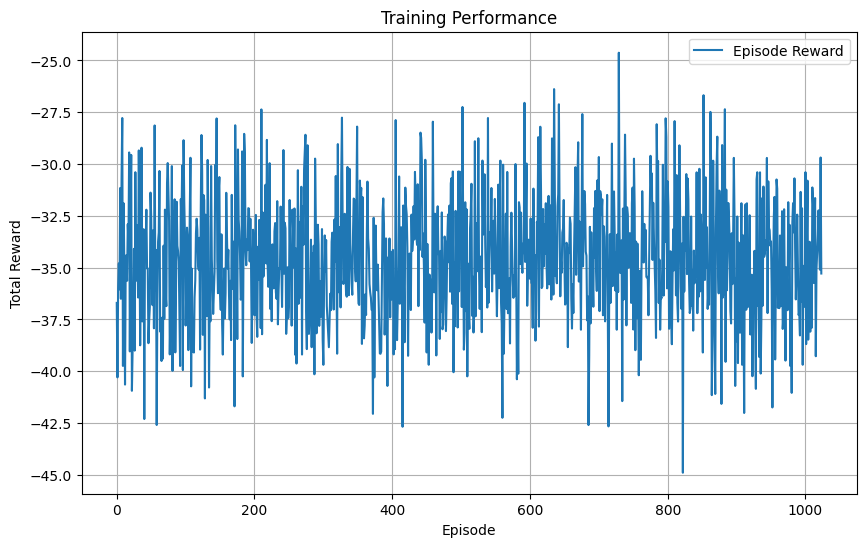

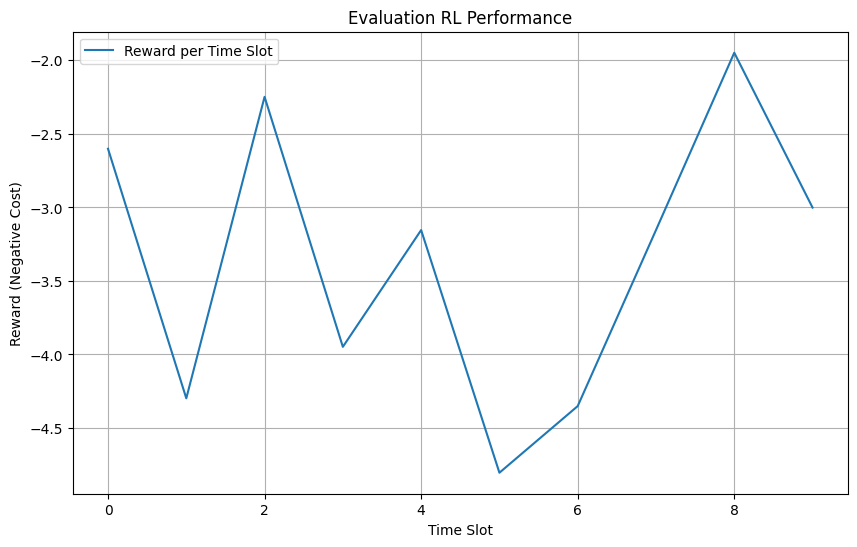

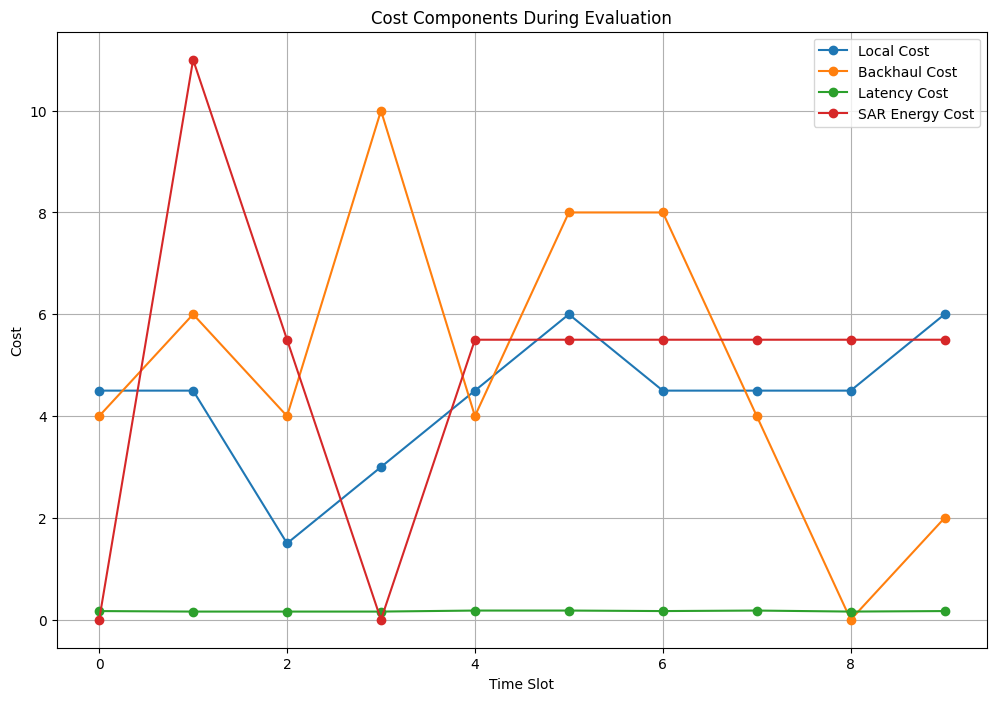

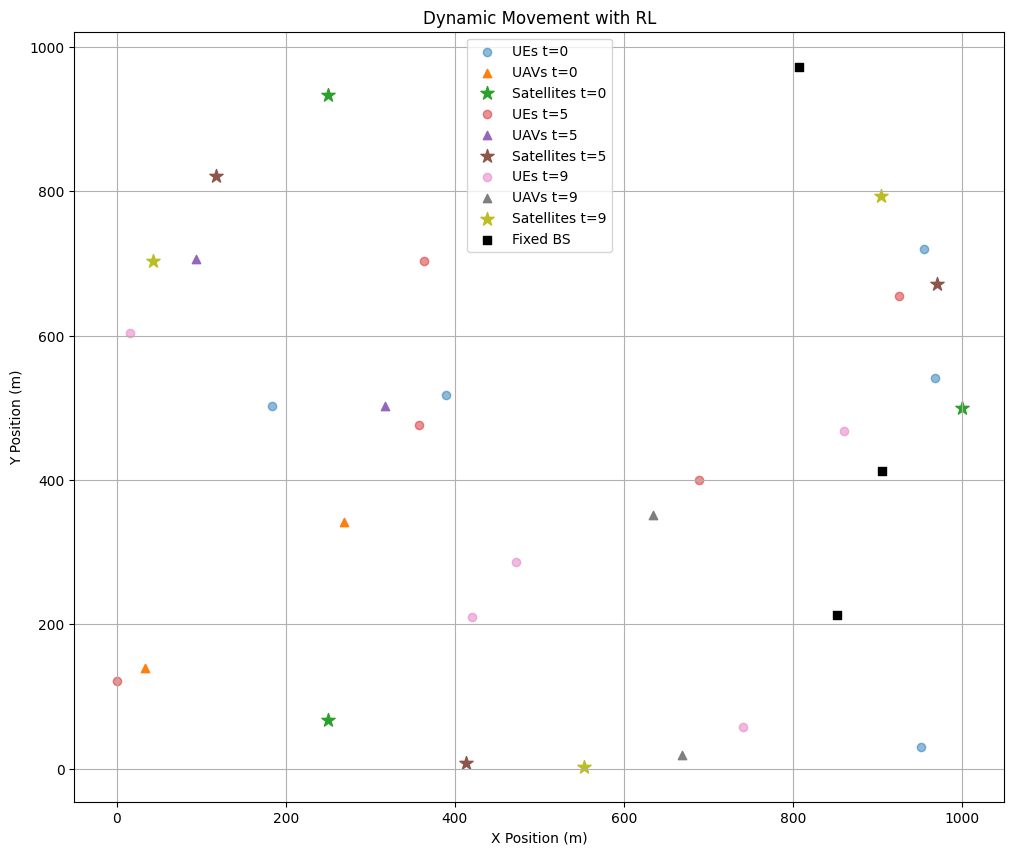

In [1]:
!pip install stable-baselines3 gymnasium torch stable-baselines3
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
T = 10
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Custom Callback for Logging Training Performance
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# Custom Environment
class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.T = T
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}  # Track costs
        self.reset()

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, T)), np.zeros((K, T))
        self.uav_x, self.uav_y = np.zeros((N // 2, T)), np.zeros((N // 2, T))
        self.sat_x, self.sat_y = np.zeros((C, T)), np.zeros((C, T))
        for t in range(T):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, T))
        for t in range(T):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}  # Reset costs
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy)

        # Log costs
        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= T
        truncated = False
        if not done:
            self.state = np.concatenate([self.uav_x[:, self.t], self.sat_x[:, self.t],self.ue_x[:, self.t],
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO with Callback
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu')
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, T//2, T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    fps             | 803      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -34.9      |
| time/                   |            |
|    fps                  | 639        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03217321 |
|    clip_fraction        | 0.424      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

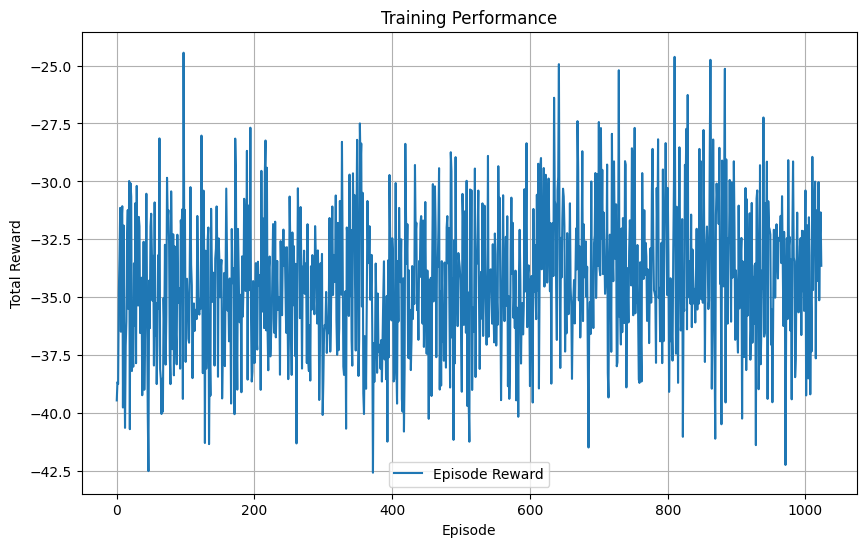

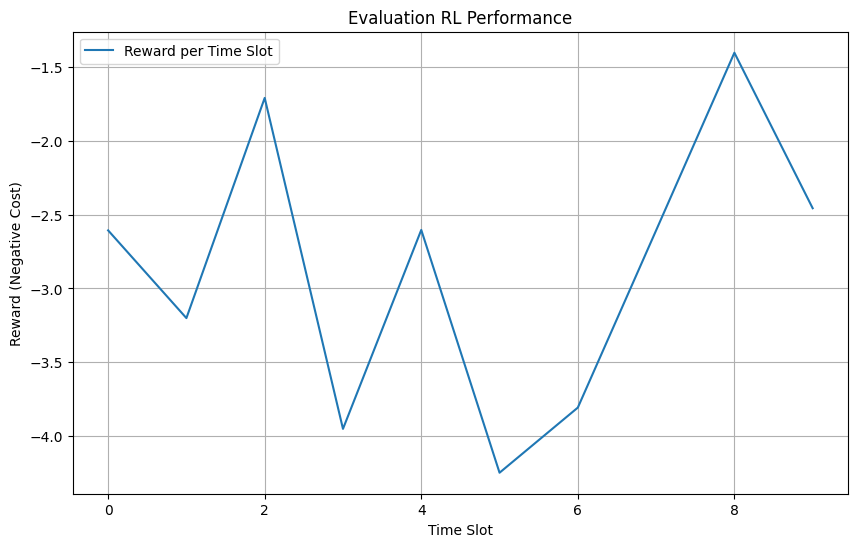

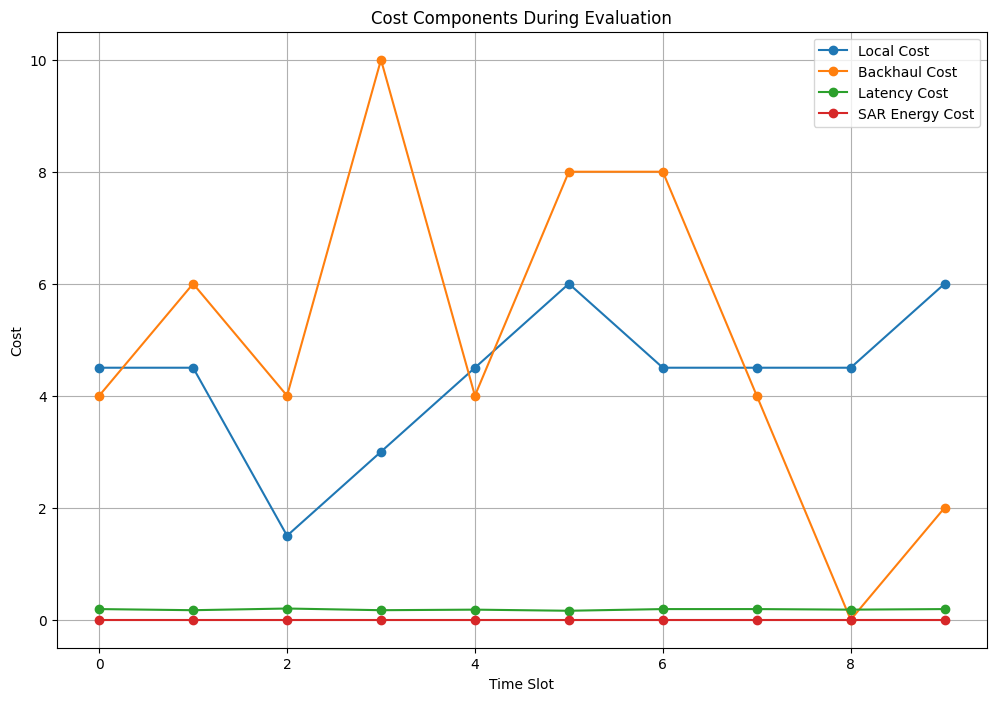

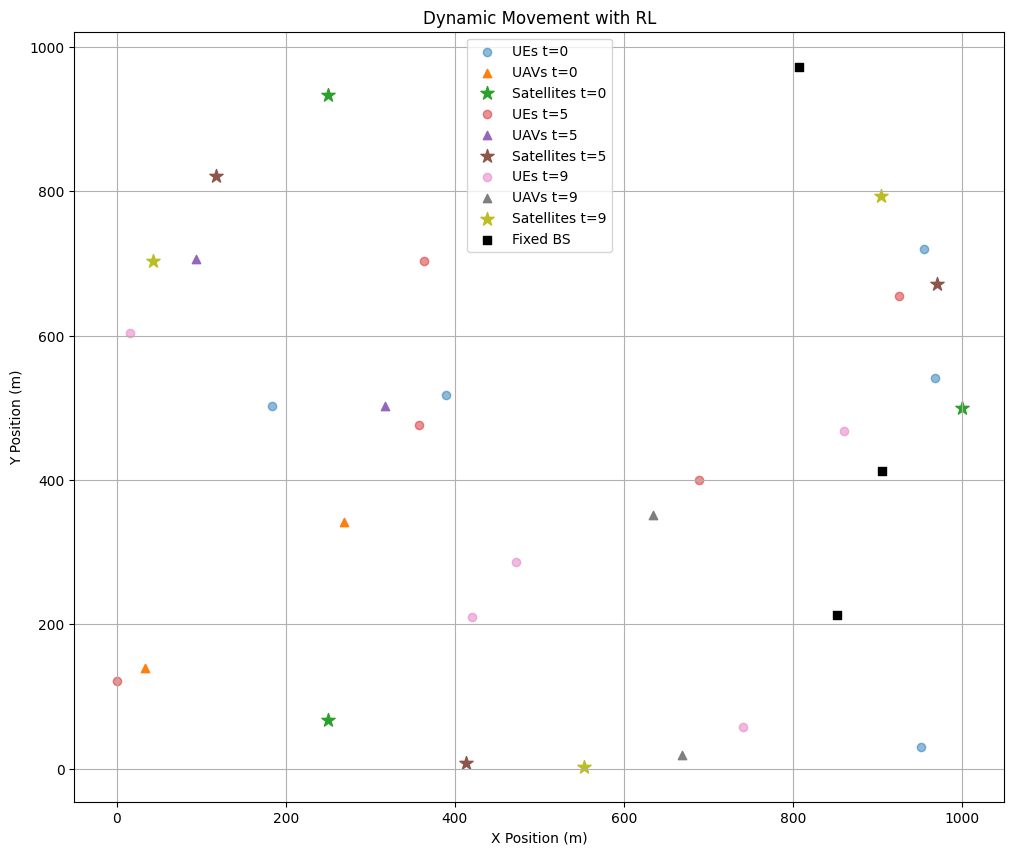

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5    # UEs
N = 5    # Nodes (N/2 UAVs, N-N/2 fixed BS)
C = 3    # Satellites
A = 2    # SAR areas
AREA_SIZE = 1000
MAX_T = 10  # Max time steps for evaluation (not in state/action)

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Training Logger Callback
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# Custom Environment (Single Time Step)
class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        # Precompute positions for all t, but only current t in state
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy)

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu')
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -49.2    |
| time/              |          |
|    fps             | 799      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -46.8      |
| time/                   |            |
|    fps                  | 640        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03552967 |
|    clip_fraction        | 0.429      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

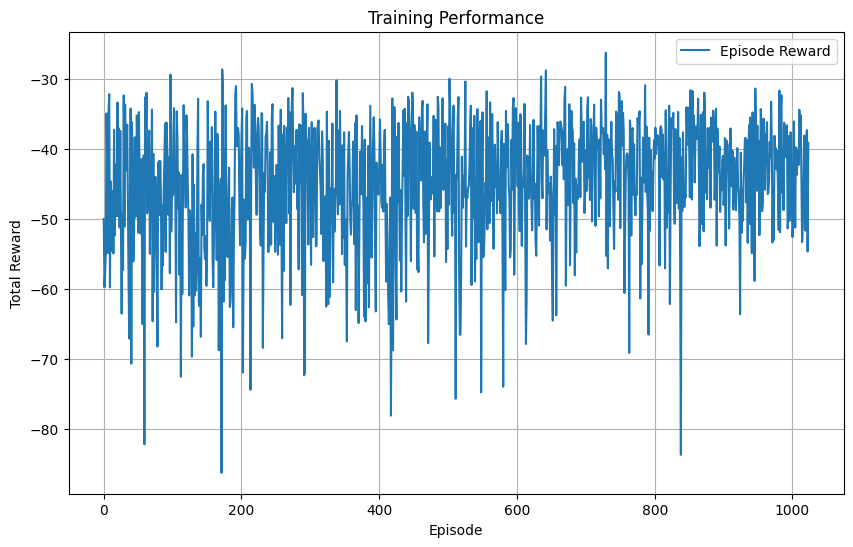

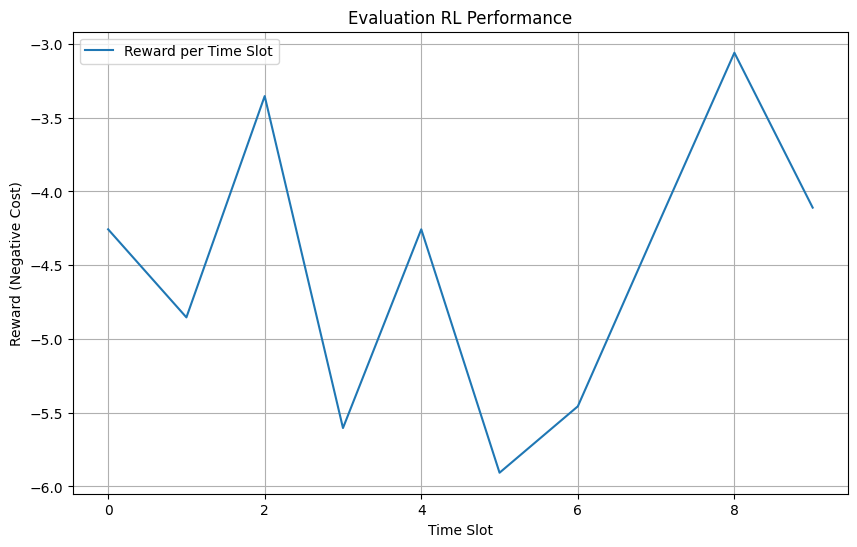

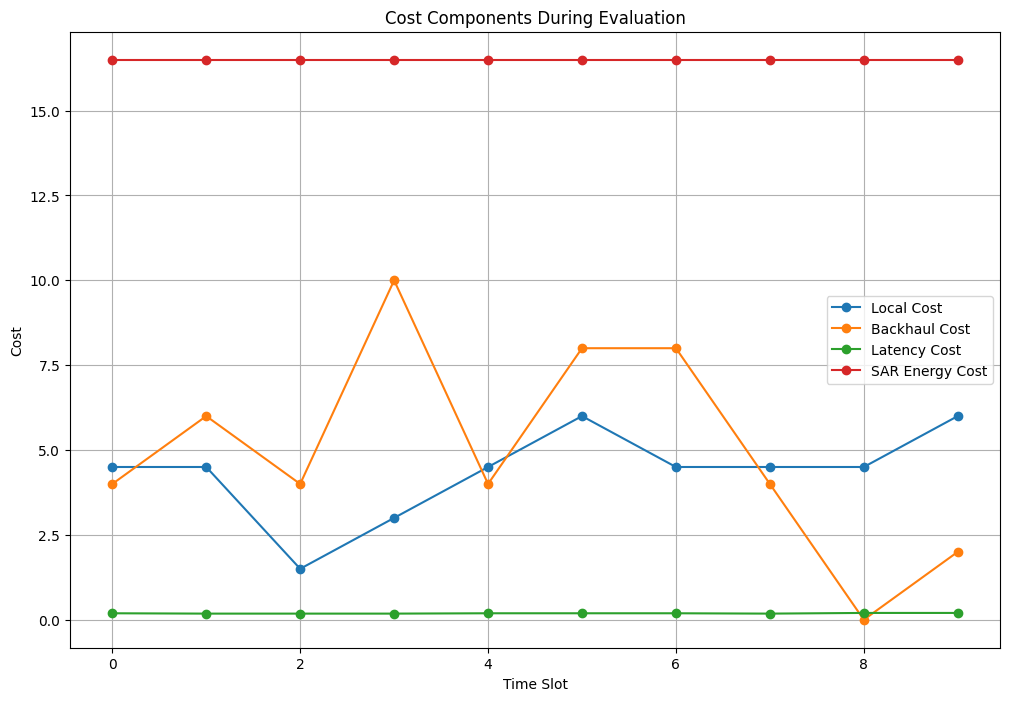

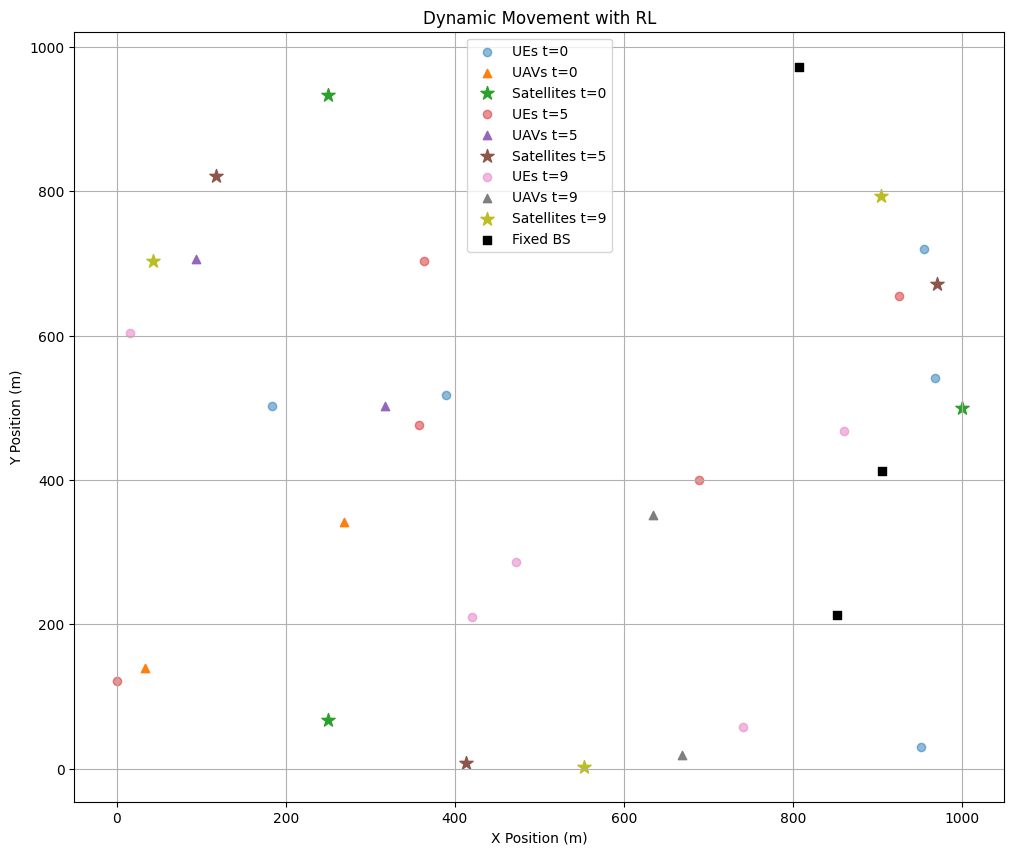

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        sar_penalty = -10.0 if sum(sar_active) == 0 else 0.0
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.01)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -109     |
| time/              |          |
|    fps             | 853      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -109       |
| time/                   |            |
|    fps                  | 657        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.07356608 |
|    clip_fraction        | 0.428      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

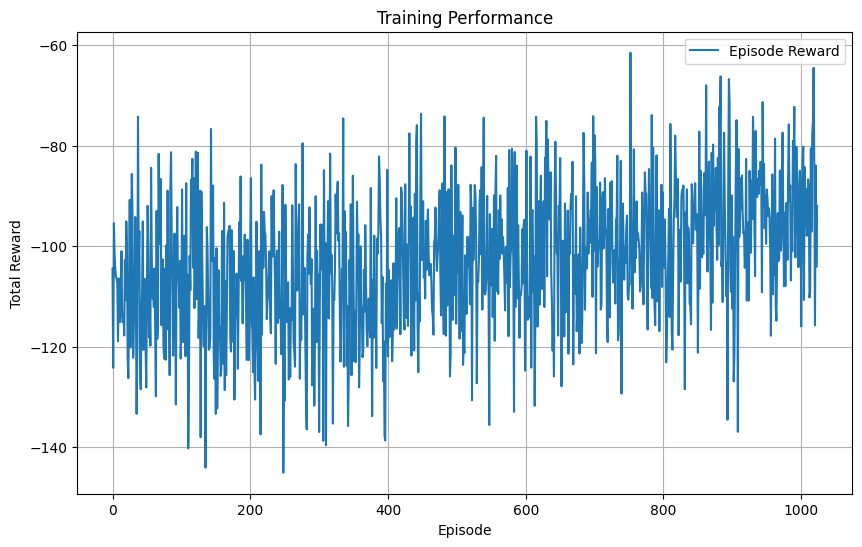

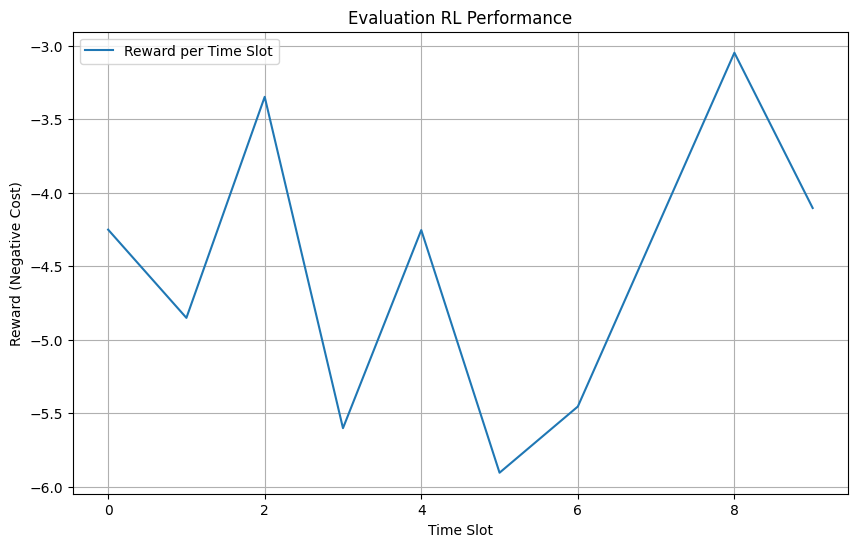

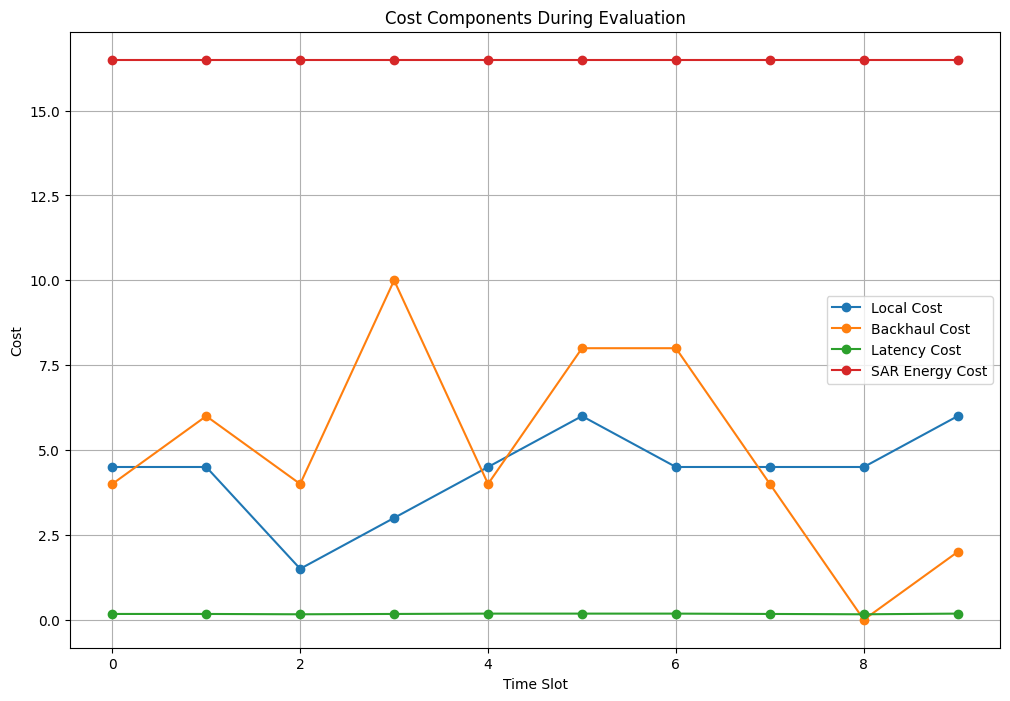

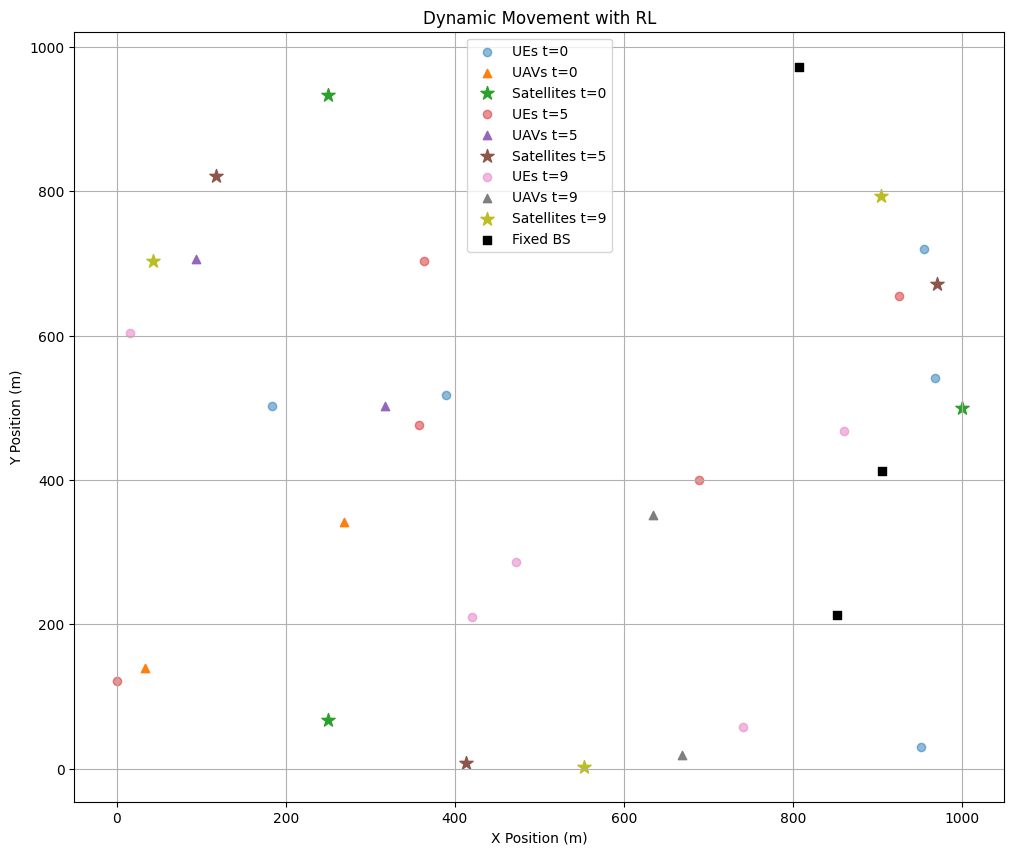

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.1)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -111     |
| time/              |          |
|    fps             | 874      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -103       |
| time/                   |            |
|    fps                  | 663        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.10074119 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

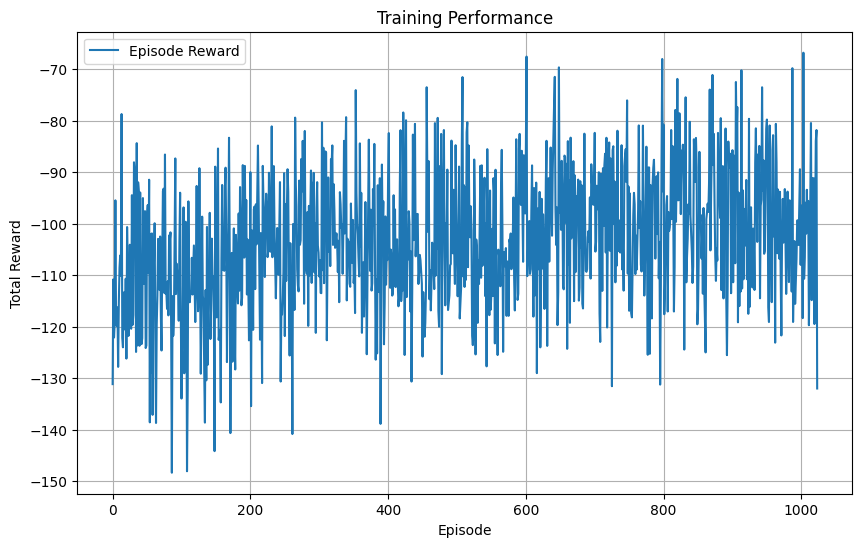

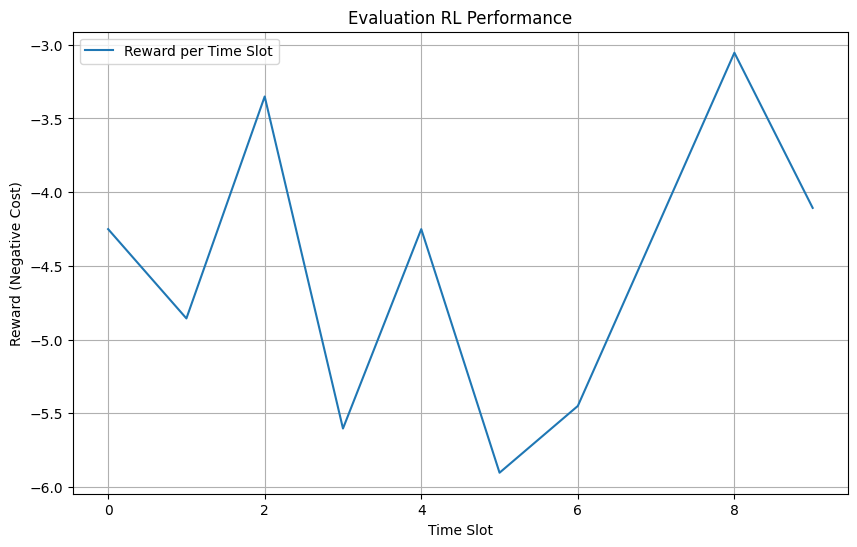

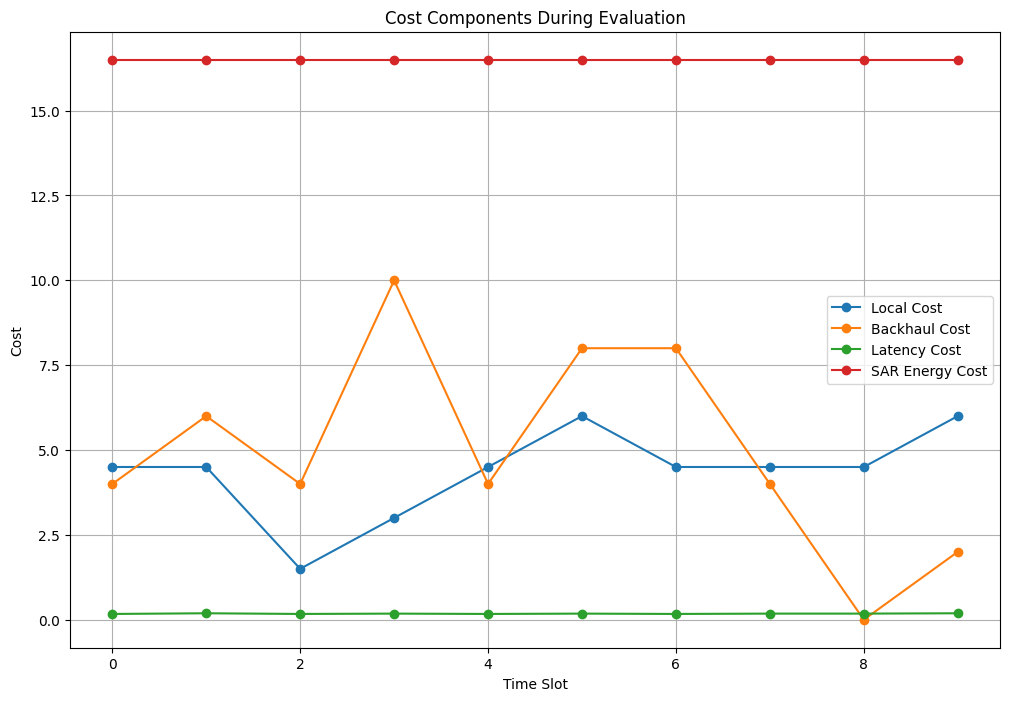

NameError: name 'self' is not defined

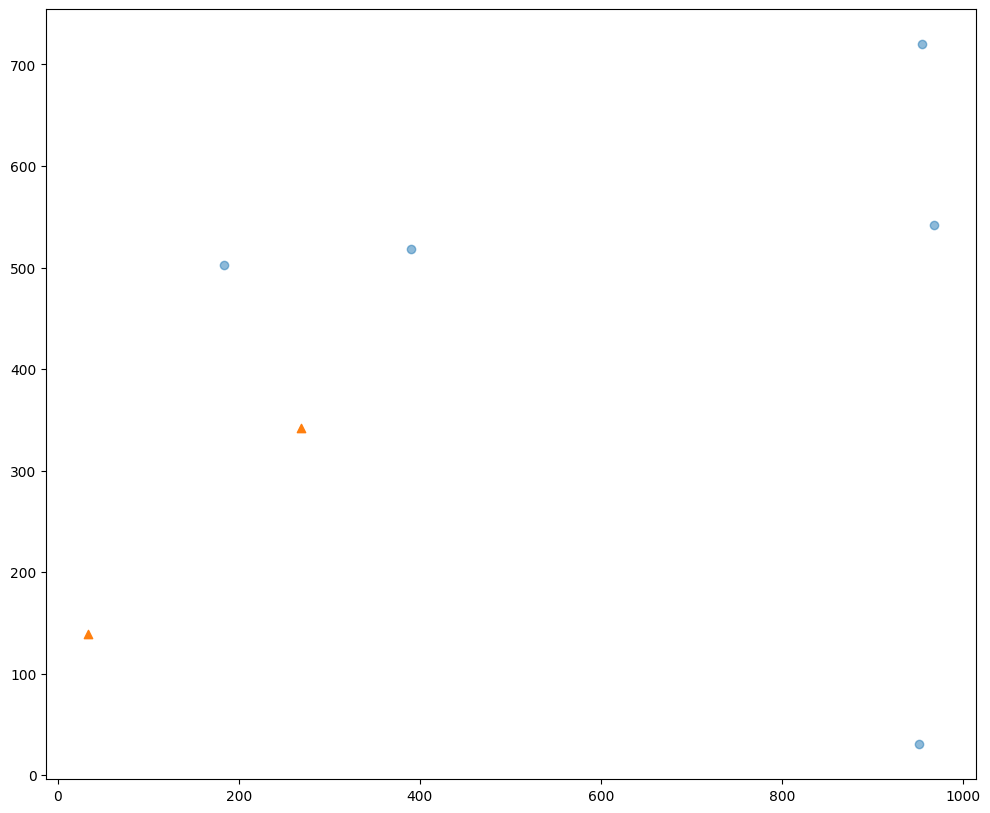

In [6]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.1)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

SyntaxError: expected ':' (735187856.py, line 292)

Running evaluations...


/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


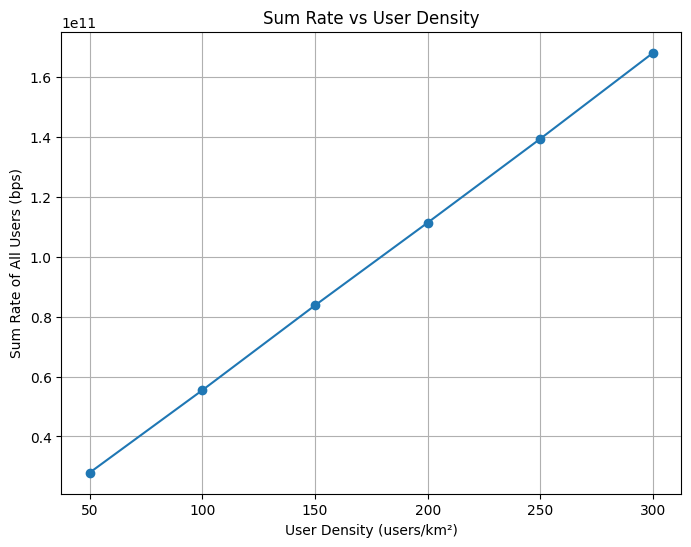

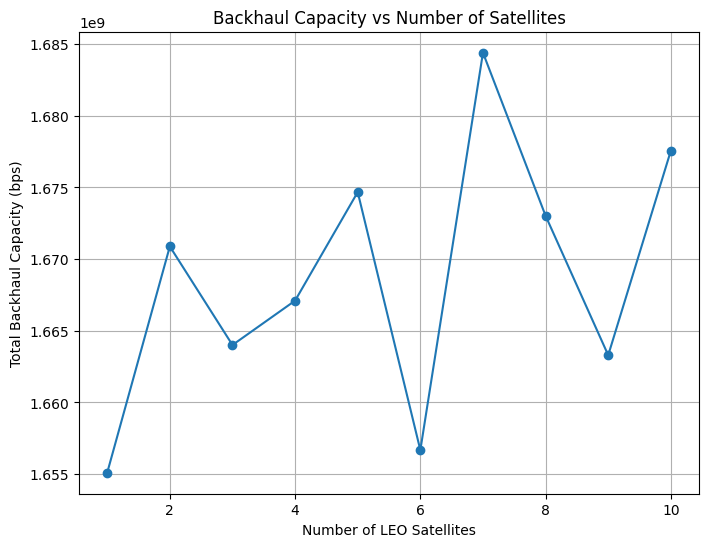

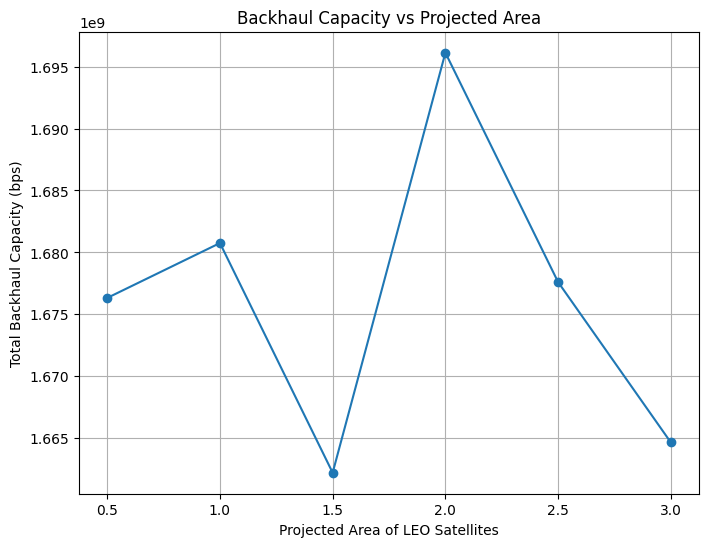

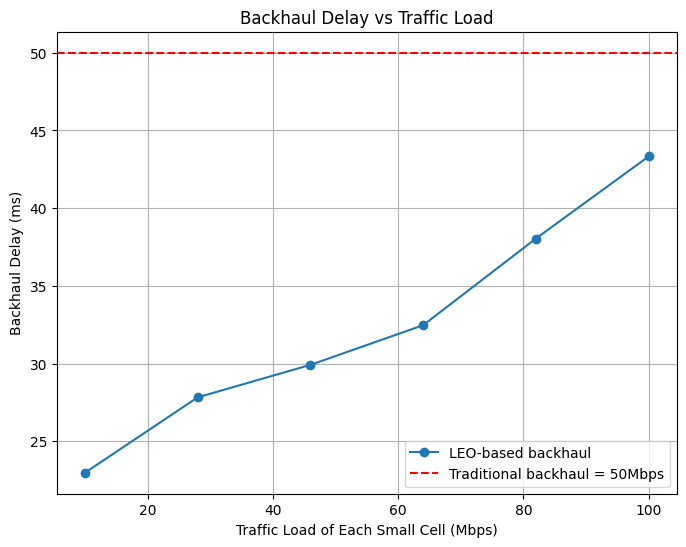

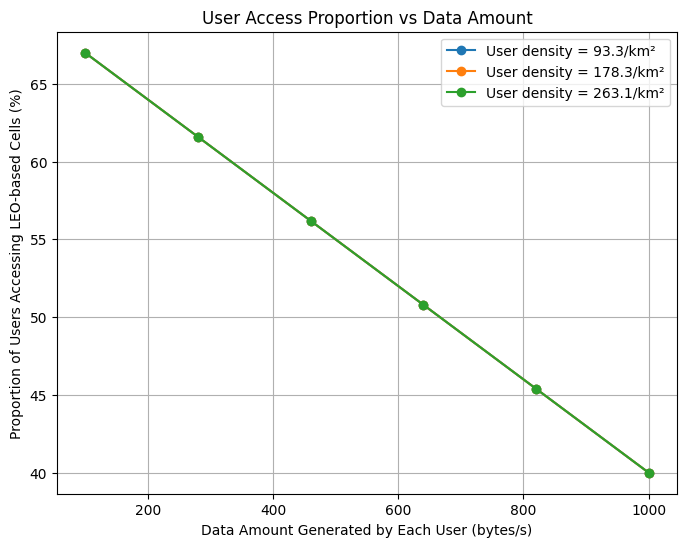

All evaluations completed!


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
import gymnasium
from gymnasium import spaces

# System Parameters
K = 5  # Number of users (will be varied for evaluation)
N = 5  # Number of base stations (will be varied for evaluation)
C = 3  # Number of LEO satellites (will be varied for evaluation)
A = 2  # Projected area factor (will be varied for evaluation)
AREA_SIZE = 1000  # Area size in meters
MAX_T = 10  # Maximum timesteps

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class BorderSurveillanceEnv(gym.Env):
    def __init__(self, K=5, N=5, C=3, A=2):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((self.K, self.max_t)), np.zeros((self.K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((self.N // 2, self.max_t)), np.zeros((self.N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((self.C, self.max_t)), np.zeros((self.C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(self.K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(self.N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(self.C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, self.N - self.N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, self.N - self.N // 2)
        self.C_n_t = np.zeros((self.N, self.max_t))
        for t in range(self.max_t):
            for n in range(self.N):
                if n < self.N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(self.K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - self.N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - self.N // 2] - self.ue_y[k, t])**2) for k in range(self.K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:self.K]
        sar_active = action[self.K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        # Calculate sum rate for all users
        sum_rate = np.sum([self.C_n_t[a, self.t] for a in ue_assignments])
        
        # Calculate backhaul capacity (sum of satellite capacities)
        backhaul_capacity = np.sum([self.C_n_t[n, self.t] for n in range(self.N) if n >= self.N // 2])
        
        # Calculate backhaul delay (simplified model)
        backhaul_delay = 20 + np.random.normal(0, 5)  # Base delay + variation
        
        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(self.N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(self.N)])
        latency = np.mean([0.15 if a < self.N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        info = {
            'sum_rate': sum_rate,
            'backhaul_capacity': backhaul_capacity,
            'backhaul_delay': backhaul_delay,
            'user_density': self.K / (AREA_SIZE/1000)**2  # users per km^2
        }
        
        return self.state.astype(np.float32), float(reward), done, truncated, info

# Evaluation Functions
def evaluate_sum_rate_vs_density():
    user_densities = np.linspace(50, 300, 6)  # users/km^2
    sum_rates = []
    
    for density in user_densities:
        K = int(density * (AREA_SIZE/1000)**2)  # Convert density to number of users
        env = BorderSurveillanceEnv(K=K, N=5, C=3, A=2)
        obs, _ = env.reset()
        total_sum_rate = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_sum_rate += info['sum_rate']
            if done or truncated:
                break
                
        sum_rates.append(total_sum_rate / MAX_T)  # Average sum rate
    
    plt.figure(figsize=(8, 6))
    plt.plot(user_densities, sum_rates, marker='o')
    plt.xlabel('User Density (users/km²)')
    plt.ylabel('Sum Rate of All Users (bps)')
    plt.title('Sum Rate vs User Density')
    plt.grid(True)
    plt.savefig('sum_rate_vs_density.png')
    plt.show()

def evaluate_backhaul_vs_satellites():
    num_satellites = np.arange(1, 11)  # From 1 to 10 satellites
    backhaul_capacities = []
    
    for C in num_satellites:
        env = BorderSurveillanceEnv(K=5, N=5, C=C, A=2)
        obs, _ = env.reset()
        total_capacity = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_capacity += info['backhaul_capacity']
            if done or truncated:
                break
                
        backhaul_capacities.append(total_capacity / MAX_T)  # Average capacity
    
    plt.figure(figsize=(8, 6))
    plt.plot(num_satellites, backhaul_capacities, marker='o')
    plt.xlabel('Number of LEO Satellites')
    plt.ylabel('Total Backhaul Capacity (bps)')
    plt.title('Backhaul Capacity vs Number of Satellites')
    plt.grid(True)
    plt.savefig('backhaul_vs_satellites.png')
    plt.show()

def evaluate_backhaul_vs_area():
    areas = np.linspace(0.5, 3, 6)  # Projected area factors
    backhaul_capacities = []
    
    for A in areas:
        env = BorderSurveillanceEnv(K=5, N=5, C=3, A=A)
        obs, _ = env.reset()
        total_capacity = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_capacity += info['backhaul_capacity']
            if done or truncated:
                break
                
        backhaul_capacities.append(total_capacity / MAX_T)  # Average capacity
    
    plt.figure(figsize=(8, 6))
    plt.plot(areas, backhaul_capacities, marker='o')
    plt.xlabel('Projected Area of LEO Satellites')
    plt.ylabel('Total Backhaul Capacity (bps)')
    plt.title('Backhaul Capacity vs Projected Area')
    plt.grid(True)
    plt.savefig('backhaul_vs_area.png')
    plt.show()

def evaluate_delay_vs_traffic():
    traffic_loads = np.linspace(10, 100, 6)  # Mbps
    delays = []
    
    for load in traffic_loads:
        env = BorderSurveillanceEnv(K=5, N=5, C=3, A=2)
        obs, _ = env.reset()
        total_delay = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            
            # Scale delay based on traffic load (simplified model)
            scaled_delay = info['backhaul_delay'] * (1 + load/100)
            total_delay += scaled_delay
            
            if done or truncated:
                break
                
        delays.append(total_delay / MAX_T)  # Average delay
    
    plt.figure(figsize=(8, 6))
    plt.plot(traffic_loads, delays, marker='o', label='LEO-based backhaul')
    plt.axhline(y=50, color='r', linestyle='--', label='Traditional backhaul = 50Mbps')
    plt.xlabel('Traffic Load of Each Small Cell (Mbps)')
    plt.ylabel('Backhaul Delay (ms)')
    plt.title('Backhaul Delay vs Traffic Load')
    plt.legend()
    plt.grid(True)
    plt.savefig('delay_vs_traffic.png')
    plt.show()

def evaluate_access_vs_data():
    data_amounts = np.linspace(100, 1000, 6)  # bytes/s
    densities = [93.3, 178.3, 263.1]  # users/km^2
    results = {d: [] for d in densities}
    
    for density in densities:
        K = int(density * (AREA_SIZE/1000)**2)
        for data in data_amounts:
            env = BorderSurveillanceEnv(K=K, N=5, C=3, A=2)
            obs, _ = env.reset()
            total_access = 0
            
            for _ in range(MAX_T):
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                
                # Model probability of accessing LEO-based cells (simplified)
                access_prob = 0.7 - 0.3 * (data/1000)  # Decreases with higher data amounts
                total_access += access_prob
                
                if done or truncated:
                    break
                    
            results[density].append((total_access / MAX_T) * 100)  # Percentage
    
    plt.figure(figsize=(8, 6))
    for density, values in results.items():
        plt.plot(data_amounts, values, marker='o', label=f'User density = {density}/km²')
    plt.xlabel('Data Amount Generated by Each User (bytes/s)')
    plt.ylabel('Proportion of Users Accessing LEO-based Cells (%)')
    plt.title('User Access Proportion vs Data Amount')
    plt.legend()
    plt.grid(True)
    plt.savefig('access_vs_data.png')
    plt.show()

# Run all evaluations
print("Running evaluations...")
evaluate_sum_rate_vs_density()
evaluate_backhaul_vs_satellites()
evaluate_backhaul_vs_area()
evaluate_delay_vs_traffic()
evaluate_access_vs_data()
print("All evaluations completed!")